# S2S RNN to predict next state

We aim to predict the next steps on time series

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [4]:
import import_ipynb

import Process_Training_Data

from Process_Training_Data import norm
from Process_Training_Data import class_to_action
from Process_Training_Data import closest_category

importing Jupyter notebook from Process_Training_Data.ipynb


### Get the data
First Import it using pandas

In [5]:
dataset_short = Process_Training_Data.get_data("./data/fromStateToAction_df (28) last.csv")

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data.normalize_data(dataset_short,action_vector)

N_STEPS = 3
position = "post"
dataset2 = Process_Training_Data.padding(normed_dataset,N_STEPS,position)

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, history_size)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:history_size + 1])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [58]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:4,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [56]:
x_train_single_sequential[0]

array([[ 1.59717363, -1.70102178,  0.6942984 ,  1.1497174 , -0.15136753,
        -0.27057772],
       [ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792]])

In [59]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (3, 6)


In [57]:
y_train_single_sequential[0]

array([[ 0.84479311, -1.35318126,  0.25876069, -0.29971865, -0.42193381,
        -0.27276035],
       [-0.47535904,  0.06233832, -1.43760069,  0.39264118,  0.55726444,
        -0.29631792],
       [-1.3592875 ,  0.31526369,  0.16161265, -0.15381411, -0.39936716,
        -0.1713984 ]])

In [60]:
BATCH_SIZE = 20
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

### Build the model

In [61]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear'))

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mse','mae'])

### Inspect the model

In [62]:
single_step_sequential_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 11)          792       
_________________________________________________________________
dense_6 (Dense)              (None, None, 6)           72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [63]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 20

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 186.9 steps, validate for 50 steps
Epoch 1/20
187/186 [==============================] - 8s 41ms/step - loss: 0.5764 - mse: 0.7229 - mae: 0.5765 - val_loss: 0.5539 - val_mse: 0.6709 - val_mae: 0.5546
Epoch 2/20
187/186 [==============================] - 1s 7ms/step - loss: 0.5297 - mse: 0.6368 - mae: 0.5298 - val_loss: 0.5156 - val_mse: 0.5931 - val_mae: 0.5163
Epoch 3/20
187/186 [==============================] - 1s 7ms/step - loss: 0.4869 - mse: 0.5568 - mae: 0.4870 - val_loss: 0.4735 - val_mse: 0.5167 - val_mae: 0.4741
Epoch 4/20
187/186 [==============================] - 1s 6ms/step - loss: 0.4465 - mse: 0.4879 - mae: 0.4466 - val_loss: 0.4362 - val_mse: 0.4518 - val_mae: 0.4367
Epoch 5/20
187/186 [==============================] - 1s 6ms/step - loss: 0.4154 - mse: 0.4355 - mae: 0.4155 - val_loss: 0.4074 - val_mse: 0.4043 - val_mae: 0.4078
Epoch 6/20
187/186 [==============================] - 1s 8ms/step - loss: 0.3937 - mse: 0.4002 - mae: 0.3937 - val_loss: 0.3881 - val_

Compute the accuracy

In [15]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [16]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states()

0.6524064


In [64]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

935/935 - 1s - loss: 0.3081 - mse: 0.2550 - mae: 0.3081


Visualize the model's training progress.

In [65]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

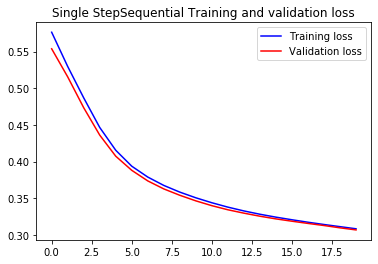

In [66]:
plot_train_history(single_step_sequential_history,
                   'Single StepSequential Training and validation loss')

#### Adding early stop

In [67]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3056,  mae:0.3056,  mse:0.2625,  val_loss:0.3042,  val_mae:0.3044,  val_mse:0.2459,  
....................

In [22]:
Last_step_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:]
m = tf.keras.metrics.Accuracy() 
_ = m.update_state(closest_category(np.array(X), y_val_single_sequential[:,N_STEPS-1,:]), closest_category(np.array(X), single_step_sequential_model.predict(x_val_single_sequential)[:,N_STEPS-1,:])) 
print(m.result().numpy())
m.reset_states() 

0.7048128


In [68]:
single_step_sequential_model.save('./data/S2S_S2S_model.h5') 